# Predictive Maintenance Model for an Industrial Pump
## This notebook will demonstrate the development of a model that provides predictions for an industrial pump's failure
## The notebook is devided into multiple sections, where each section was designed for a specific role
### The sections are as follow:
#### 1.     Import libraries, machine learning models and performance metrics tools
#### 2.     Data Exploration
#### 3.     Data Pre-Processing
#### 4.     Model 1 Development
#### 5.     Model 2 Development
#### 6.     Simulation on the models
#### 7.     Advanced Feature Engineering Attempt

### Finally, the best model performance will be highlighted, and the final results of that model will be printed into a csv file showing the probability of failure for each instance in the simulated dataset. 

## 1.     Import libraries, machine learning models and performance metrics tools

In [105]:
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import joblib


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Import machine learning models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Import performance metrics and data preprocessing tools
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from pandas.plotting import autocorrelation_plot

# Import additional libraries for model tuning and persistence
import pickle
import datetime
import xgboost as xgb

# Set up for plotting within Jupyter Notebooks
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell

## 2. Data Exploration

In [106]:
rand_state = 1000                                # Set a random seed for reproducibility
pd.set_option('display.max_columns', None)       # Ensure all columns are displayed
InteractiveShell.ast_node_interactivity = "all"  # Display multiple outputs in Jupyter cells

In [ ]:
# Load the dataset
# The directory below needs to be changed depending on the location in which the dataset is saved

df = pd.read_csv("pump_failure_dataset.csv") 

In [10]:
# View the dataframe that contains the dataset

df

timestamp  vibration_level  temperature_C  pressure_PSI  \
0    2024-01-01 00:00:00         0.549671      76.996777     93.248217   
1    2024-01-01 01:00:00         0.486174      74.623168     98.554813   
2    2024-01-01 02:00:00         0.564769      70.298152     92.075801   
3    2024-01-01 03:00:00         0.652303      66.765316     96.920385   
4    2024-01-01 04:00:00         0.476585      73.491117     81.063853   
..                   ...              ...            ...           ...   
995  2024-02-11 11:00:00         0.471890      75.350751    100.774805   
996  2024-02-11 12:00:00         0.679769      69.867394    102.577525   
997  2024-02-11 13:00:00         0.564084      65.590627     87.582394   
998  2024-02-11 14:00:00         0.442882      69.184665    103.341764   
999  2024-02-11 15:00:00         0.557258      66.275487     98.447410   

     flow_rate_m3h  failure  
0        40.460962        0  
1        45.698075        0  
2        47.931972        0  
3        59.438438        0  
4        52.782766        0  
..             ...      ...  
995      50.142288        0  
996      39.610941        1  
997      48.398511        0  
998      58.216891        0  
999      51.803239        0  

[1000 rows x 6 columns]

In [108]:
# Initial dataset overview

df.info()  # Print summary information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        1000 non-null   object 
 1   vibration_level  1000 non-null   float64
 2   temperature_C    1000 non-null   float64
 3   pressure_PSI     1000 non-null   float64
 4   flow_rate_m3h    1000 non-null   float64
 5   failure          1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [109]:
# Convert the timestamp to datetime format

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [14]:
# Display statistical summaries and failure cases

df.describe()                           # Show statistical description of the data
failure = df['failure'].value_counts()  # Count the number of failure vs non-failure cases
ratio_cases = failure / len(df.index)   # Calculate the ratio of failure and non-failure cases


print(f'Ratio of failure cases: {ratio_cases[1]}\nRatio of non-failure cases: {ratio_cases[0]}')
failure

timestamp  vibration_level  temperature_C  \
count                           1000      1000.000000    1000.000000   
mean   2024-01-21 19:29:59.999999744         0.501933      70.354181   
min              2024-01-01 00:00:00         0.175873      55.298057   
25%              2024-01-11 09:45:00         0.435241      66.968792   
50%              2024-01-21 19:30:00         0.502530      70.315386   
75%              2024-02-01 05:15:00         0.564794      73.644411   
max              2024-02-11 15:00:00         0.885273      85.965538   
std                              NaN         0.097922       4.987272   

       pressure_PSI  flow_rate_m3h      failure  
count   1000.000000    1000.000000  1000.000000  
mean     100.058342      49.906404     0.049000  
min       69.804878      35.352757     0.000000  
25%       93.520004      46.312898     0.000000  
50%       99.997492      50.000923     0.000000  
75%      106.609153      53.334727     0.000000  
max      139.262377      66.215465     1.000000  
std        9.834543       5.135663     0.215976

Ratio of failure cases: 0.049
Ratio of non-failure cases: 0.951


failure
0    951
1     49
Name: count, dtype: int64

In [15]:
# Create a copy of the dataset for visualization

df2 = df[['timestamp', 'failure']].copy()
df2 = df2.set_index('timestamp')             # Set the timestamp as the index

<Axes: title={'center': 'Failure VS. Non-Failure Cases'}, xlabel='failure'>

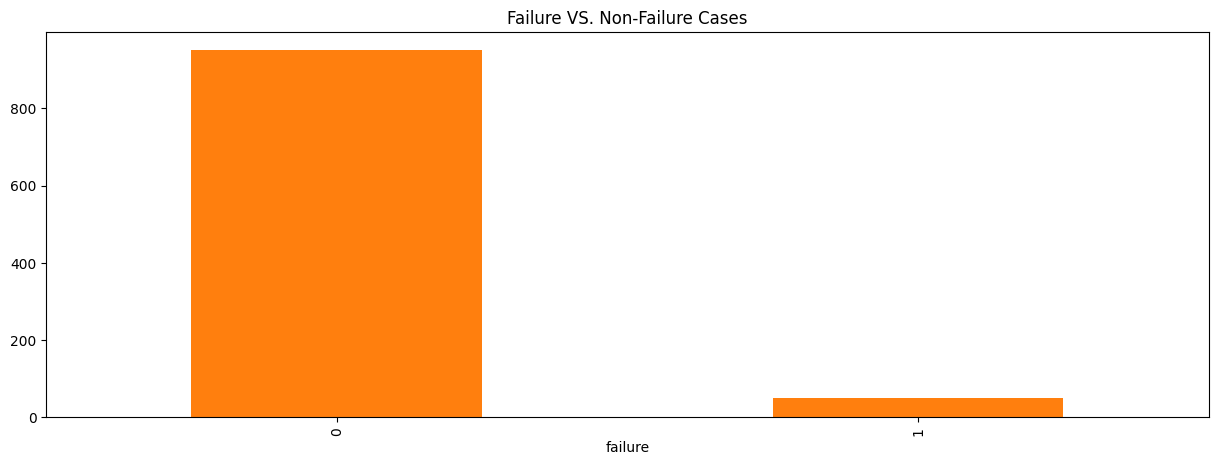

In [16]:
# Plot failure vs. non-failure cases

df2['failure'].value_counts().plot(kind='bar', figsize=(15, 5), color=sns.color_palette()[1], title='Failure VS. Non-Failure Cases')
plt.show()

In [49]:
# Calculate a correlation matrix

correlation_matrix = df.corr()

# Display the correlation matrix

print(correlation_matrix)

                 timestamp  vibration_level  temperature_C  pressure_PSI  \
timestamp         1.000000         0.035484      -0.027804      0.019423   
vibration_level   0.035484         1.000000      -0.040400      0.022129   
temperature_C    -0.027804        -0.040400       1.000000     -0.011199   
pressure_PSI      0.019423         0.022129      -0.011199      1.000000   
flow_rate_m3h     0.005470        -0.013321      -0.054698      0.021586   
failure           0.008465         0.021784       0.052382      0.235530   

                 flow_rate_m3h   failure  
timestamp             0.005470  0.008465  
vibration_level      -0.013321  0.021784  
temperature_C        -0.054698  0.052382  
pressure_PSI          0.021586  0.235530  
flow_rate_m3h         1.000000 -0.274590  
failure              -0.274590  1.000000  


<Figure size 1000x800 with 0 Axes>

<Axes: >

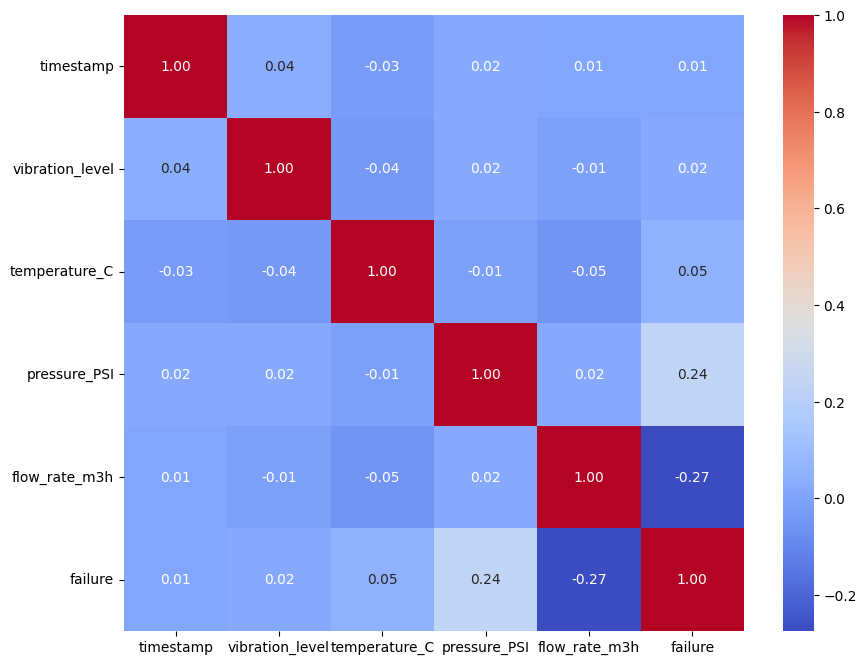

In [50]:
# Plot a heatmap of the correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Vibration Level')

Text(0.5, 1.0, 'Vibration Level Over Time')

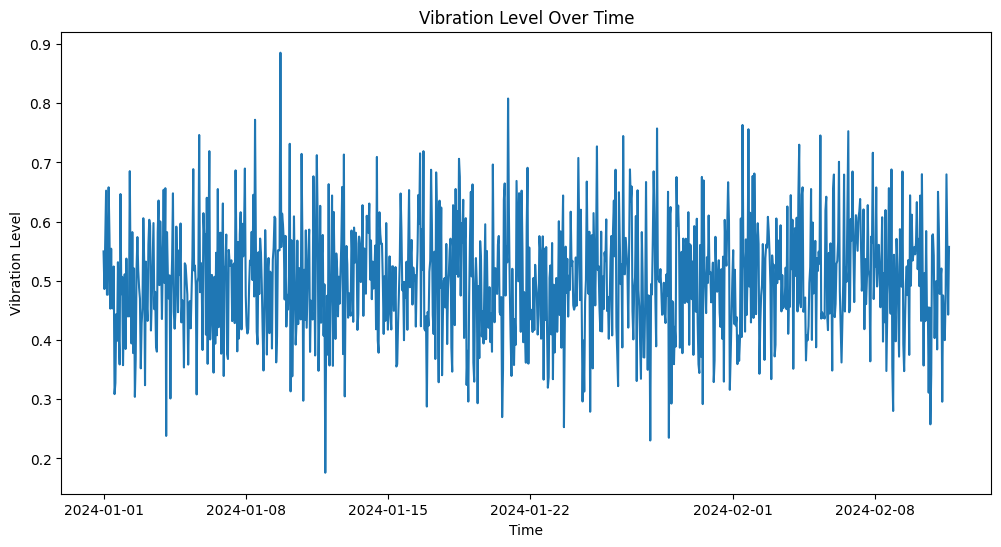

In [53]:
# Ploting the vibration level over time

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['vibration_level'])
plt.xlabel('Time')
plt.ylabel('Vibration Level')
plt.title('Vibration Level Over Time')
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'temperature_C')

Text(0.5, 1.0, 'Temperature in degrees Celsius Over Time')

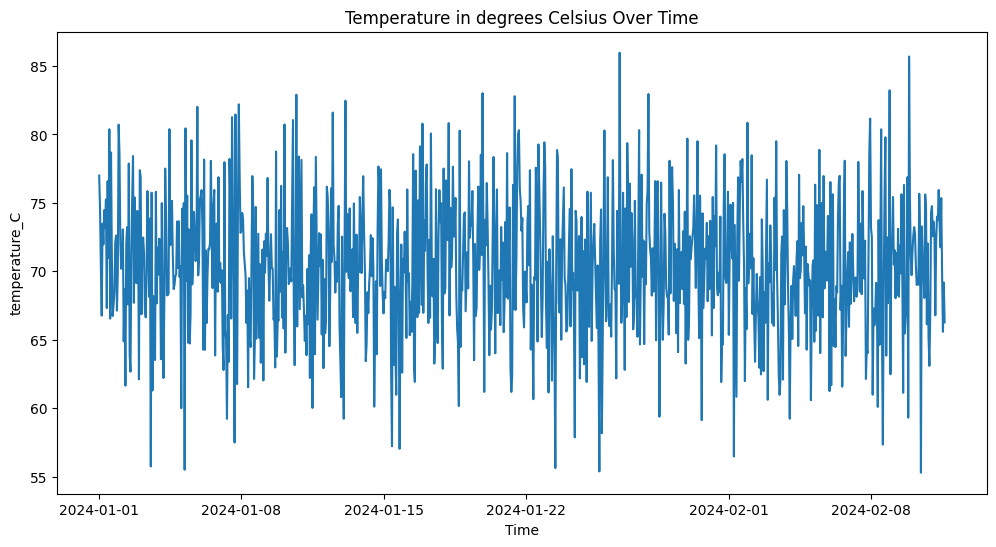

In [54]:
# Ploting the temperature_C over time

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['temperature_C'])
plt.xlabel('Time')
plt.ylabel('temperature_C')
plt.title('Temperature in degrees Celsius Over Time')
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'pressure_PSI')

Text(0.5, 1.0, 'Pressure in PSI Over Time')

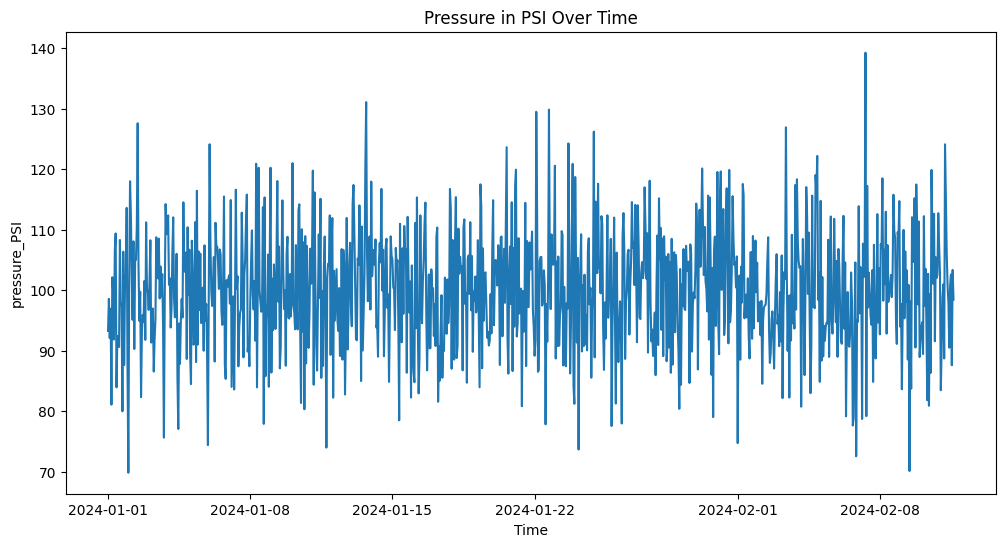

In [55]:
# Ploting the pressure_PSI over time

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['pressure_PSI'])
plt.xlabel('Time')
plt.ylabel('pressure_PSI')
plt.title('Pressure in PSI Over Time')
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'flow_rate_m3h')

Text(0.5, 1.0, 'Flow Rate in m3/h Over Time')

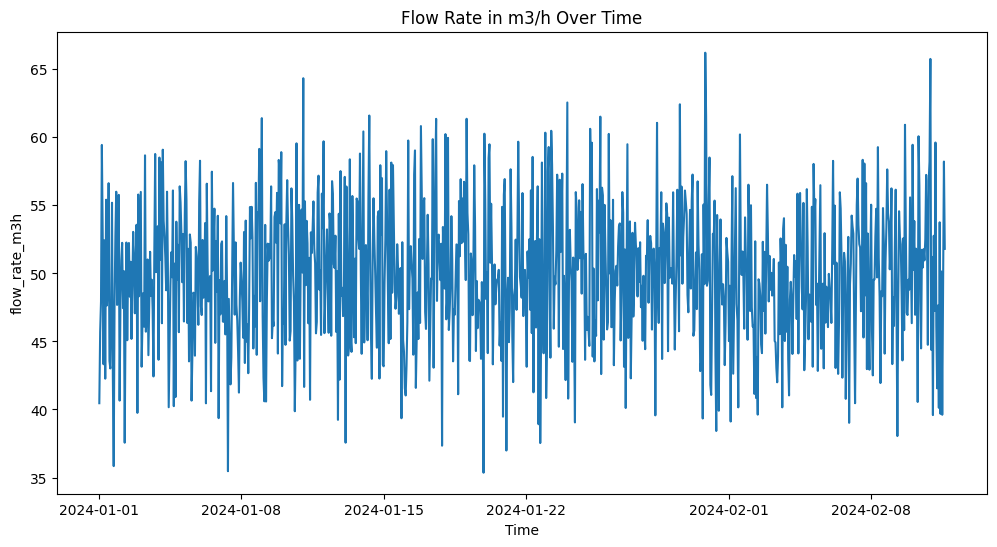

In [56]:
# Ploting the flow_rate_m3h over time

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['flow_rate_m3h'])
plt.xlabel('Time')
plt.ylabel('flow_rate_m3h')
plt.title('Flow Rate in m3/h Over Time')
plt.show()

## 3. Data Pre-Processing

In [17]:
# Sample a subset of data for training

sample_train = df.sample(800, random_state=42).reset_index(drop=True)
print(sample_train.shape)                                              # Print the shape of the sampled training data

(800, 6)


In [19]:
# Calculate and display the proportion of each class label in the 'failure' column of the sampled training data

sample_train['failure'].value_counts(normalize = True)

failure
0    0.95125
1    0.04875
Name: proportion, dtype: float64

In [20]:
# Save sampled data to a CSV file

sample_train.to_csv('failure_train_sample.csv', index=False)

### Further Analysis and Visualizations

In [21]:
# Load the sampled data

df3 = pd.read_csv('failure_train_sample.csv')

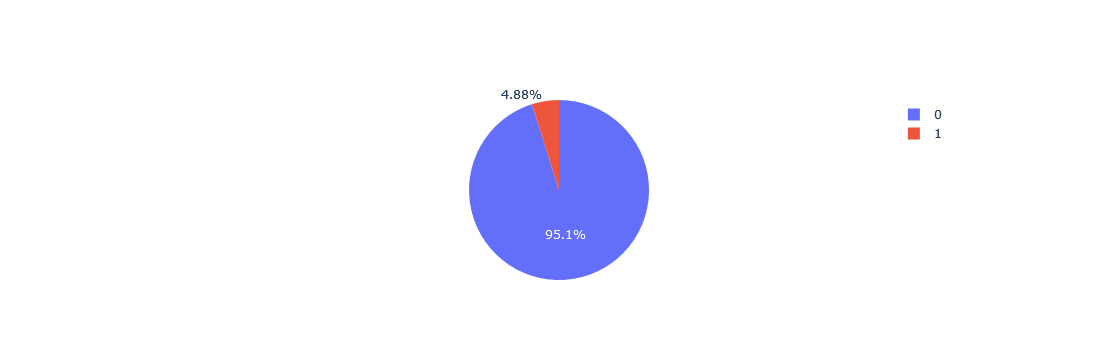

In [22]:
# Plot data distribution using pie chart

labels = list(df3['failure'].value_counts().index)
values = list(df3['failure'].value_counts().values)
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

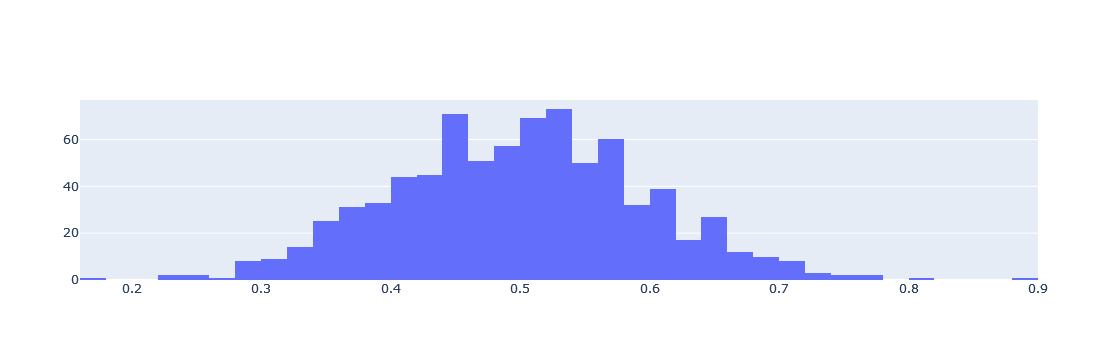

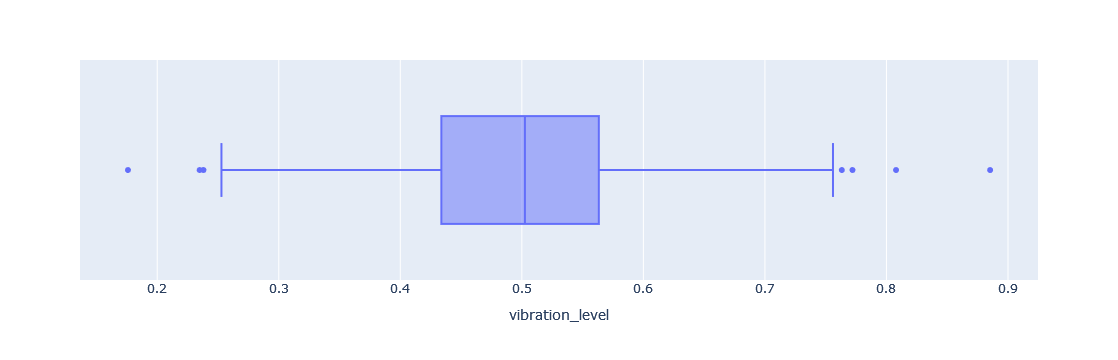

In [27]:
# Plot histograms and box plots for exploratory analysis of vibration levels

fig = go.Figure(data=[go.Histogram(x=df3['vibration_level'])])
fig.show()
fig = px.box(df3, x="vibration_level")
fig.show()

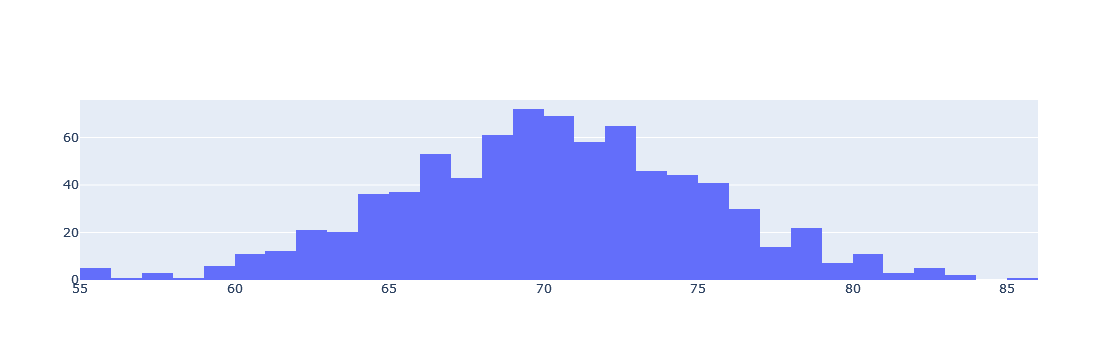

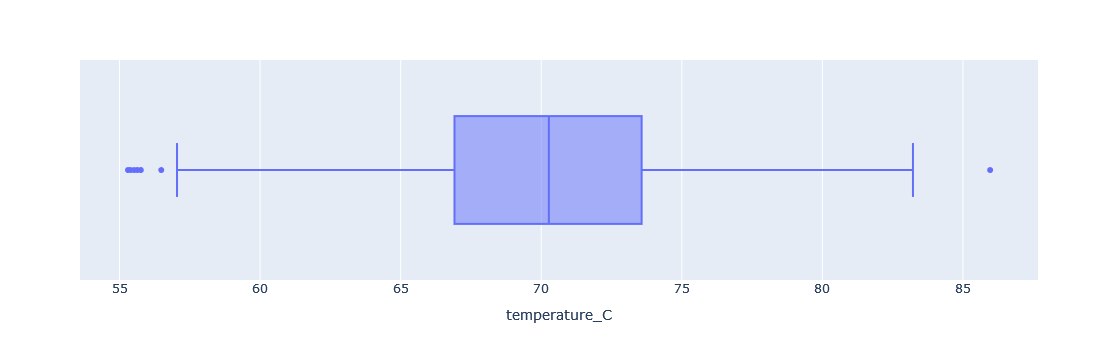

In [28]:
# Plot histograms and box plots for exploratory analysis of temperature_C

fig = go.Figure(data=[go.Histogram(x=df3['temperature_C'])])
fig.show()
fig = px.box(df3, x="temperature_C")
fig.show()

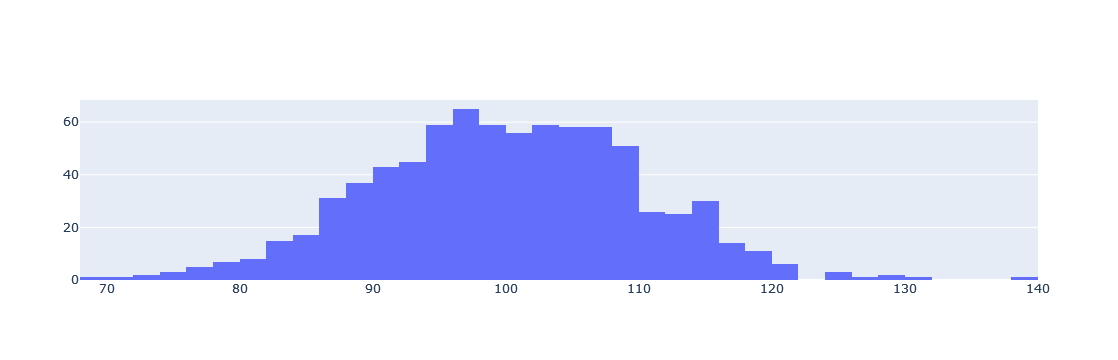

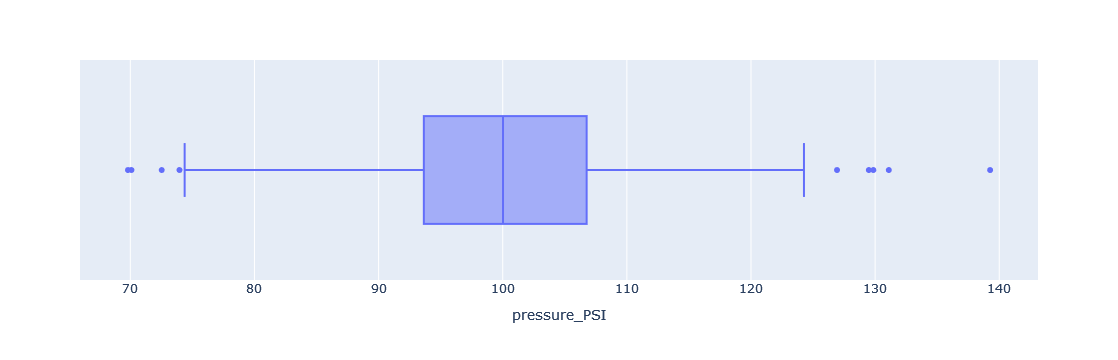

In [29]:
# Plot histograms and box plots for exploratory analysis of pressure_PSI

fig = go.Figure(data=[go.Histogram(x=df3['pressure_PSI'])])
fig.show()
fig = px.box(df3, x="pressure_PSI")
fig.show()

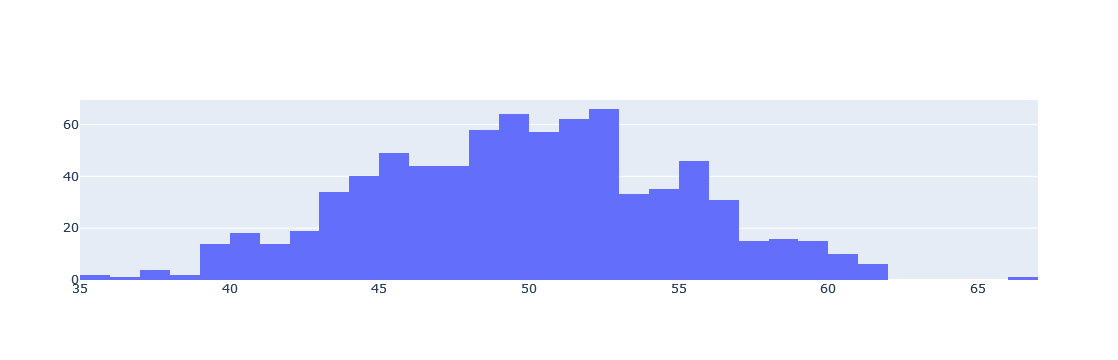

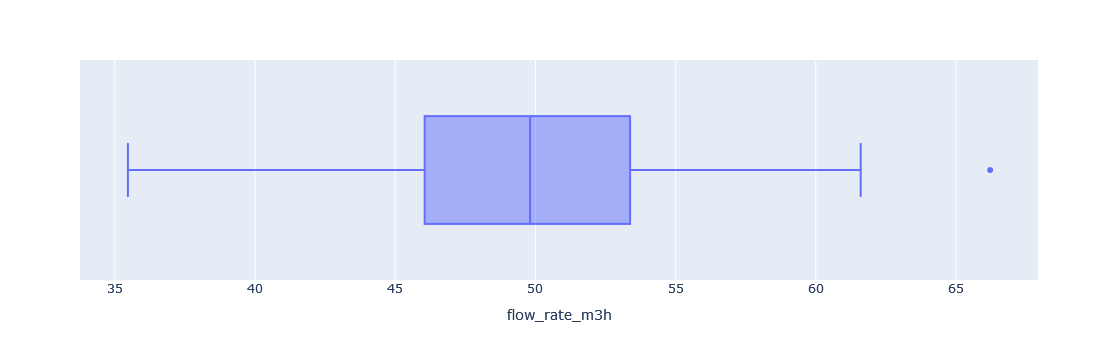

In [30]:
# Plot histograms and box plots for exploratory analysis of flow_rate_m3h

fig = go.Figure(data=[go.Histogram(x=df3['flow_rate_m3h'])])
fig.show()
fig = px.box(df3, x="flow_rate_m3h")
fig.show()

### Normalization

In [32]:
# Separate features and target variable

X = df3.drop(columns=['timestamp', 'failure'])  
y = df3['failure']

In [33]:
# Standardize the feature columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df3 = pd.DataFrame(X_scaled, columns=X.columns)  # Convert to DataFrame
print(X_scaled_df3.head())                                # Display first few rows of scaled data

   vibration_level  temperature_C  pressure_PSI  flow_rate_m3h
0         0.560544       0.534175      2.994905      -2.379033
1         1.011660      -1.125251      0.336231      -0.116173
2        -1.887648      -0.156335      0.409191      -0.654586
3        -0.586443       1.273437     -1.190748      -0.310741
4        -1.152203       0.508158      1.538951      -0.352467


## 4. Model 1 Development

### Feature Engineering for Model 1

In [34]:
# Creating rolling averages for a 5-period window

X_scaled_df3['vibration_rolling_mean'] = X_scaled_df3['vibration_level'].rolling(window=5).mean()

In [35]:
# Creating a lagged feature for temperature

X_scaled_df3['temperature_lag1'] = X_scaled_df3['temperature_C'].shift(1)

In [36]:
# Dropping any Null values resulting from the rolling or lagging

X_scaled_df3.dropna(inplace=True)

In [39]:
# Display a few rows of scaled data with the new features

print(X_scaled_df3.head())

   vibration_level  temperature_C  pressure_PSI  flow_rate_m3h  \
4        -1.152203       0.508158      1.538951      -0.352467   
5         0.963386       0.952792      0.087766       1.193768   
6        -1.013543      -0.501188      1.403587      -0.770587   
7        -0.929301      -1.928597     -0.264622      -1.656097   
8         0.652518       0.210542      0.187118      -0.151104   

   vibration_rolling_mean  temperature_lag1  
4               -0.410818          1.273437  
5               -0.330250          0.508158  
6               -0.735290          0.952792  
7               -0.543621         -0.501188  
8               -0.295829         -1.928597  


In [40]:
# Creating interaction terms

X_scaled_df3['pressure_temp_interaction'] = X_scaled_df3['pressure_PSI'] * X_scaled_df3['temperature_C']
print(X_scaled_df3.head())

   vibration_level  temperature_C  pressure_PSI  flow_rate_m3h  \
4        -1.152203       0.508158      1.538951      -0.352467   
5         0.963386       0.952792      0.087766       1.193768   
6        -1.013543      -0.501188      1.403587      -0.770587   
7        -0.929301      -1.928597     -0.264622      -1.656097   
8         0.652518       0.210542      0.187118      -0.151104   

   vibration_rolling_mean  temperature_lag1  pressure_temp_interaction  
4               -0.410818          1.273437                   0.782031  
5               -0.330250          0.508158                   0.083622  
6               -0.735290          0.952792                  -0.703461  
7               -0.543621         -0.501188                   0.510350  
8               -0.295829         -1.928597                   0.039396  


In [41]:
# Combining the features and target

final_df = pd.concat([X_scaled_df3, y], axis=1)

print(final_df.head())

   vibration_level  temperature_C  pressure_PSI  flow_rate_m3h  \
4        -1.152203       0.508158      1.538951      -0.352467   
5         0.963386       0.952792      0.087766       1.193768   
6        -1.013543      -0.501188      1.403587      -0.770587   
7        -0.929301      -1.928597     -0.264622      -1.656097   
8         0.652518       0.210542      0.187118      -0.151104   

   vibration_rolling_mean  temperature_lag1  pressure_temp_interaction  \
4               -0.410818          1.273437                   0.782031   
5               -0.330250          0.508158                   0.083622   
6               -0.735290          0.952792                  -0.703461   
7               -0.543621         -0.501188                   0.510350   
8               -0.295829         -1.928597                   0.039396   

   failure  
4        0  
5        0  
6        0  
7        0  
8        0  


### Analysing the data after the feature engineering step

array([[<Axes: title={'center': 'vibration_level'}>,
        <Axes: title={'center': 'temperature_C'}>,
        <Axes: title={'center': 'pressure_PSI'}>],
       [<Axes: title={'center': 'flow_rate_m3h'}>,
        <Axes: title={'center': 'vibration_rolling_mean'}>,
        <Axes: title={'center': 'temperature_lag1'}>],
       [<Axes: title={'center': 'pressure_temp_interaction'}>, <Axes: >,
        <Axes: >]], dtype=object)

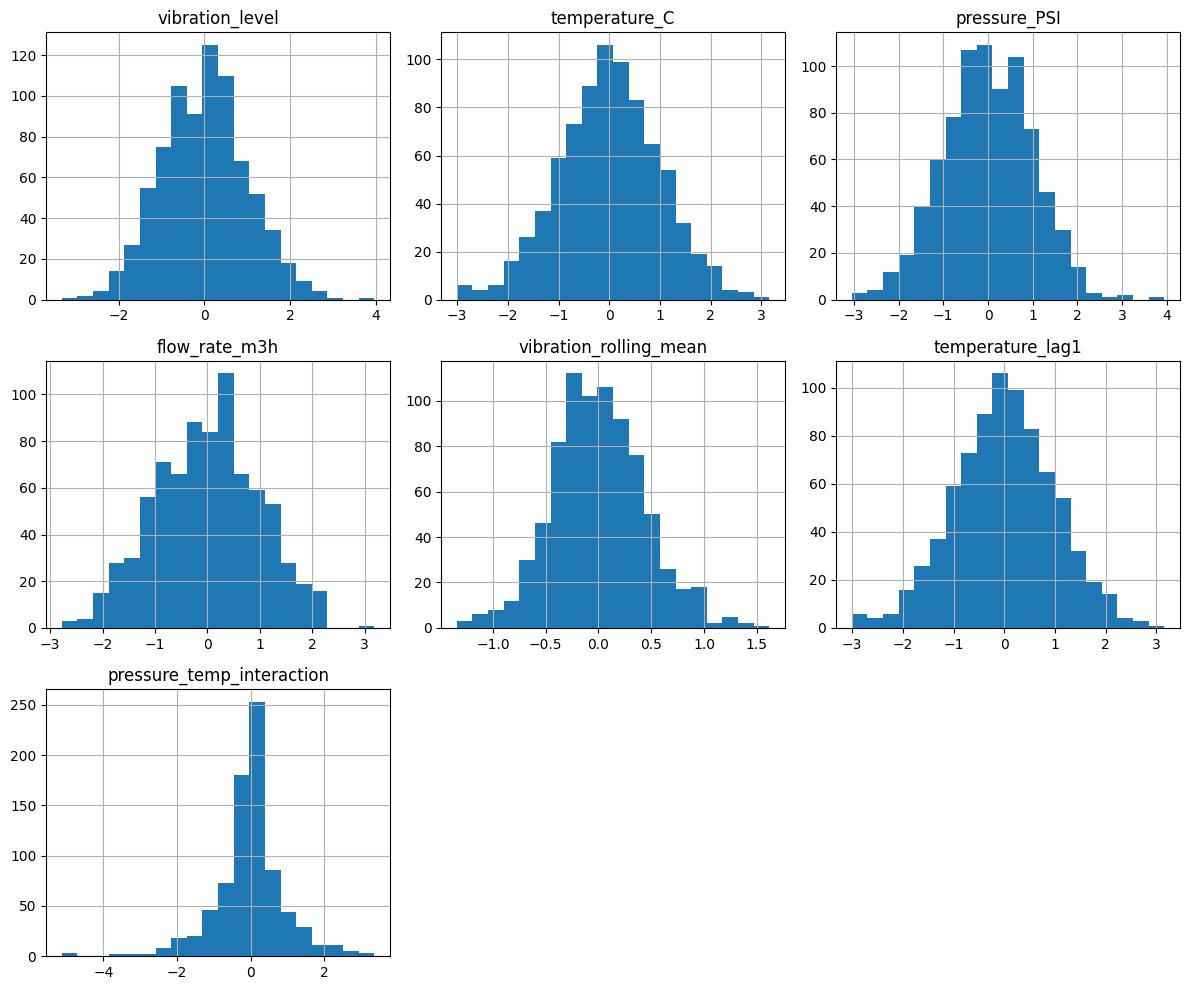

In [42]:
# Plot histograms for each feature

X_scaled_df3.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: >

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'vibration_level'),
  Text(1, 0, 'temperature_C'),
  Text(2, 0, 'pressure_PSI'),
  Text(3, 0, 'flow_rate_m3h'),
  Text(4, 0, 'vibration_rolling_mean'),
  Text(5, 0, 'temperature_lag1'),
  Text(6, 0, 'pressure_temp_interaction')])

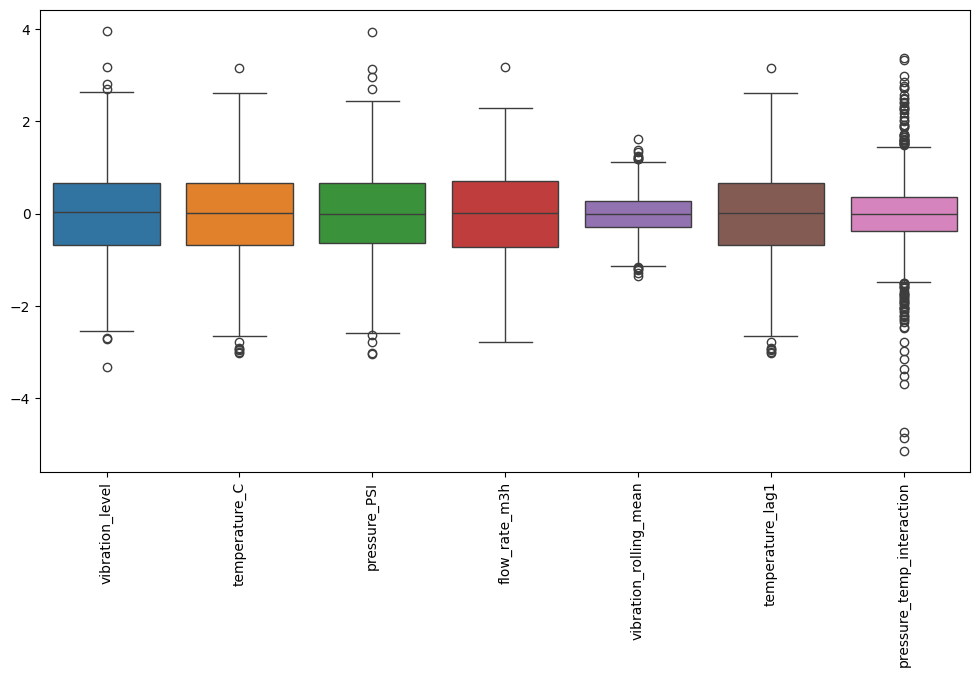

In [43]:
# Plot box plots for each feature

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df3)
plt.xticks(rotation=90)
plt.show()

In [51]:
# Calculate a correlation matrix

correlation_matrix = final_df.corr()

# Display the correlation matrix

print(correlation_matrix)

                           vibration_level  temperature_C  pressure_PSI  \
vibration_level                   1.000000      -0.055989      0.033559   
temperature_C                    -0.055989       1.000000     -0.019059   
pressure_PSI                      0.033559      -0.019059      1.000000   
flow_rate_m3h                    -0.026027      -0.047881      0.030381   
vibration_rolling_mean            0.426706       0.023163     -0.016331   
temperature_lag1                  0.014142       0.016262      0.007806   
pressure_temp_interaction         0.038541       0.038891     -0.037837   
failure                           0.034254       0.042212      0.213229   

                           flow_rate_m3h  vibration_rolling_mean  \
vibration_level                -0.026027                0.426706   
temperature_C                  -0.047881                0.023163   
pressure_PSI                    0.030381               -0.016331   
flow_rate_m3h                   1.000000            

<Figure size 1000x800 with 0 Axes>

<Axes: >

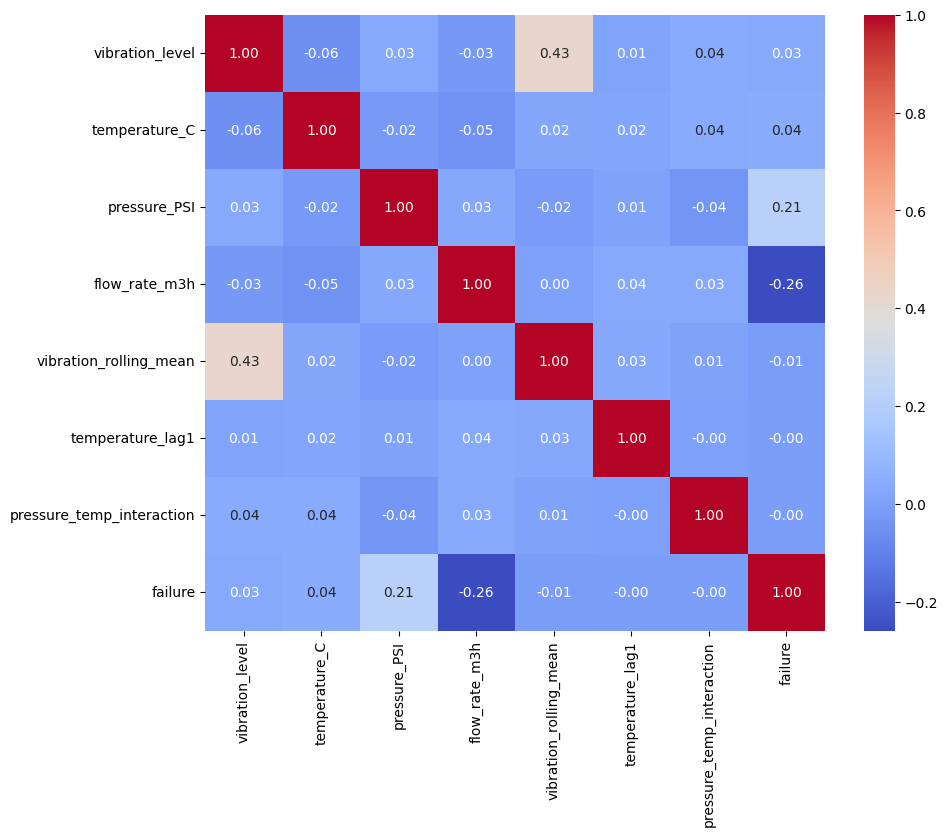

In [52]:
# Plot a heatmap of the correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [57]:
# Combine X_scaled_df3 and y into one DataFrame before any operations that change their length

final_df = pd.concat([X_scaled_df3, y], axis=1)

In [58]:
# Dropping all null values

final_df.dropna(inplace=True)

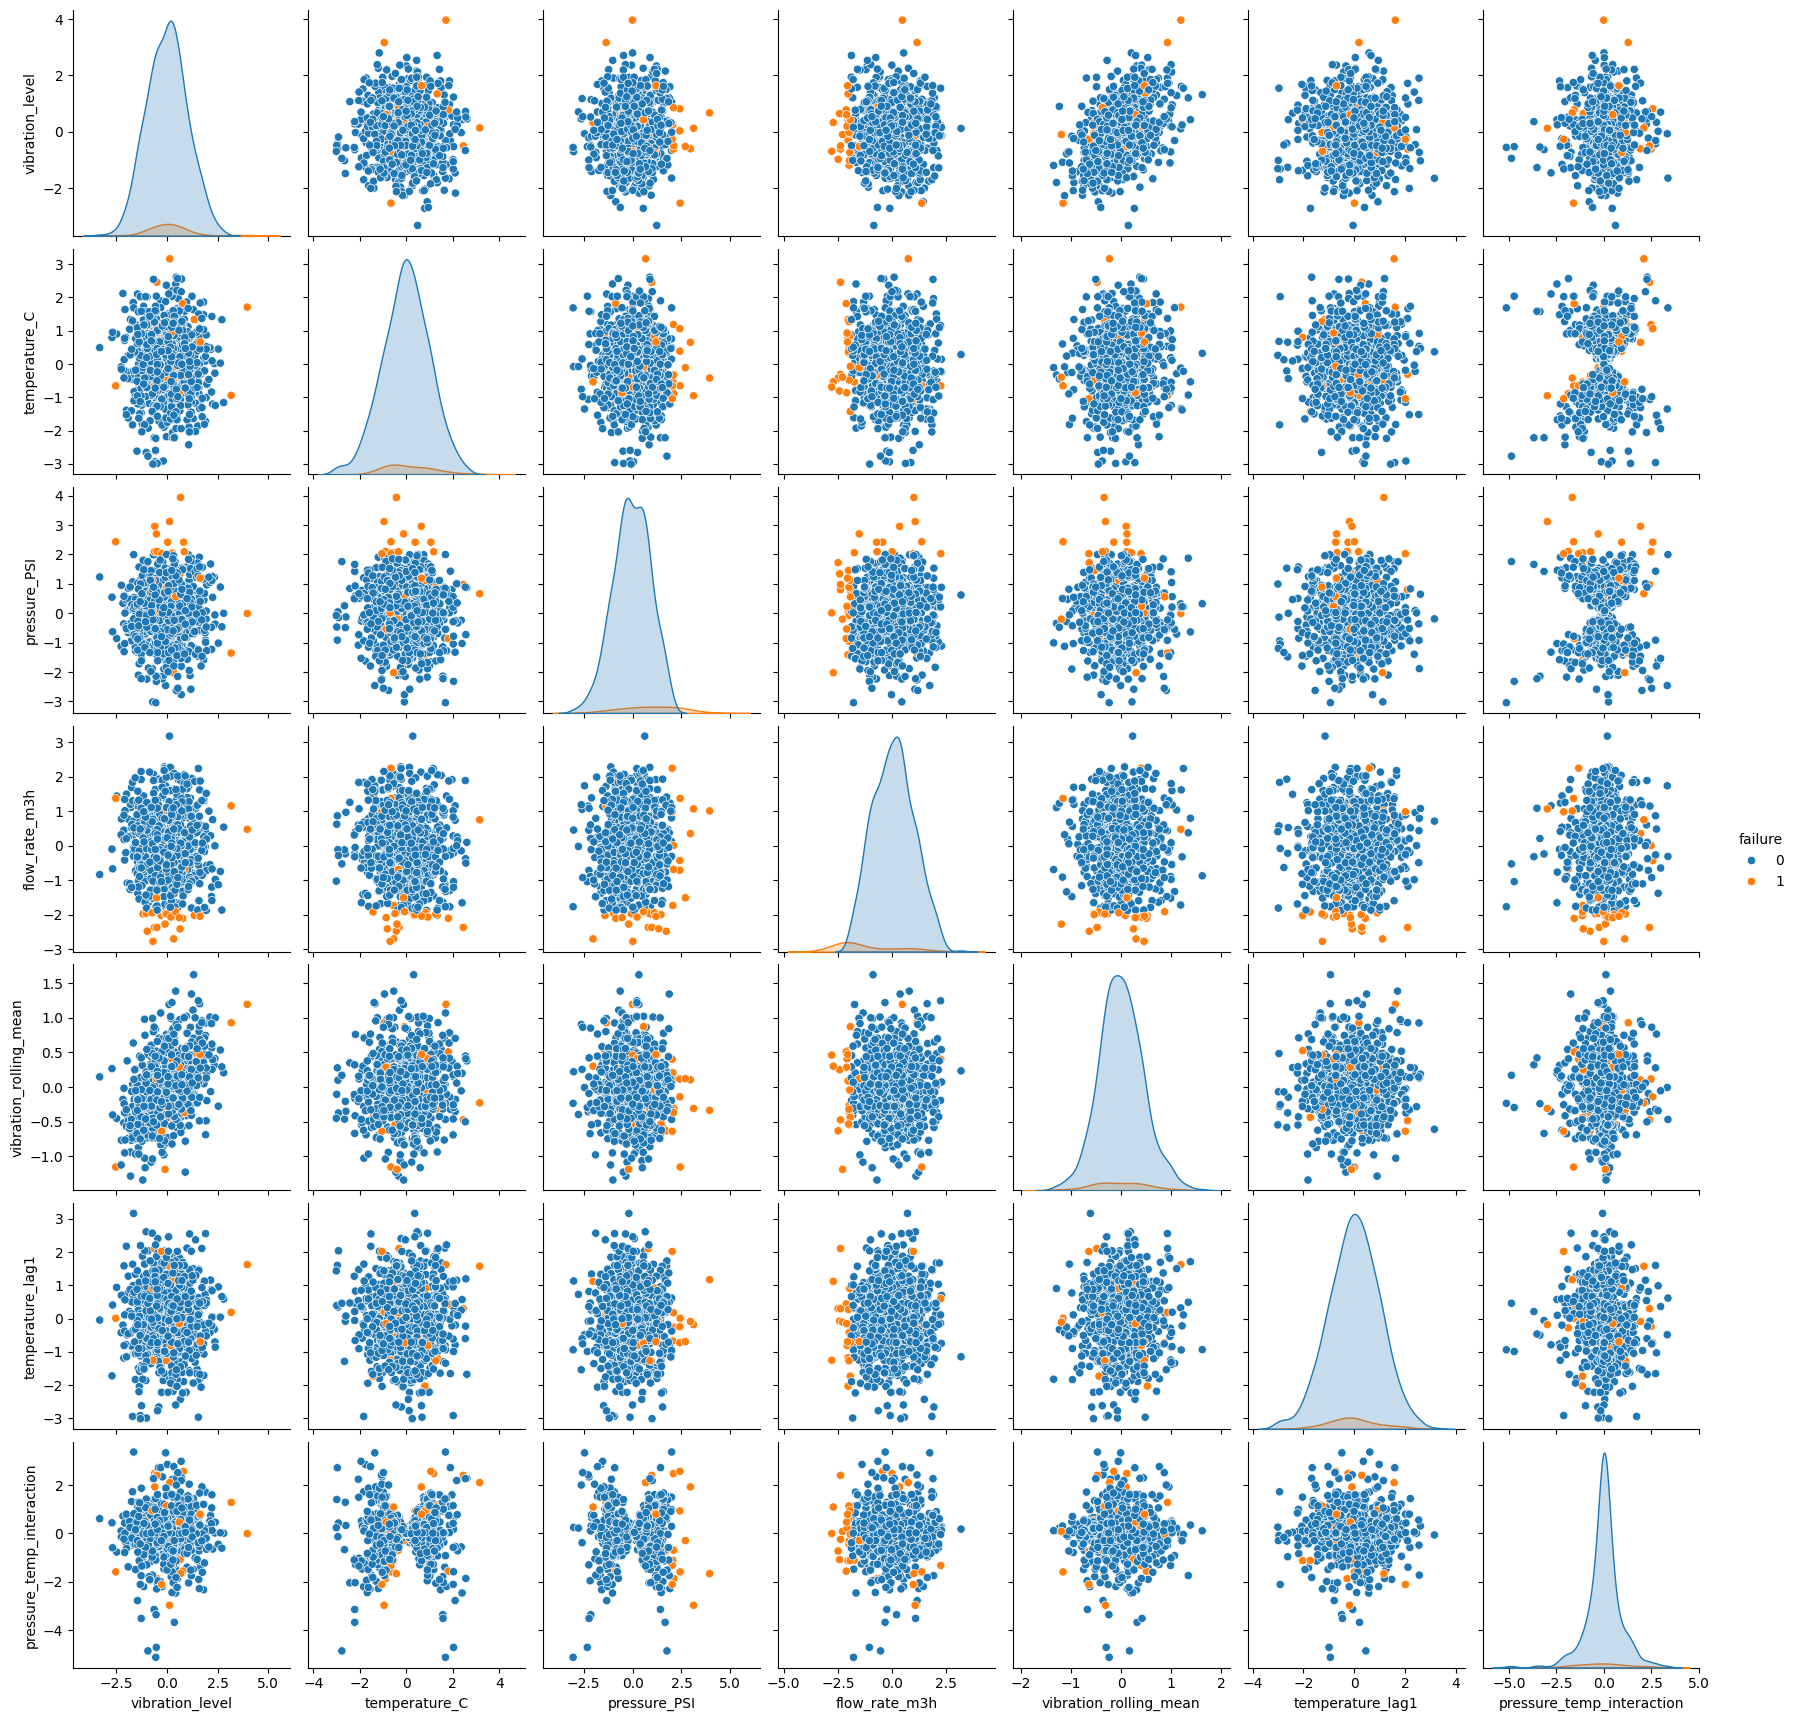

In [60]:
# Showing a scatter plot for all the features and the failure instances

sns.pairplot(final_df, hue='failure', diag_kind='kde')
plt.show()

### Model 1 training

In [61]:
# The final_df DataFrame contains the processed features and the target variable 'failure'

X = final_df.drop(columns=['failure'])  # Features
y = final_df['failure']                 # Target variable

In [62]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Initializing the Random Forest classifier

rf_model = RandomForestClassifier(random_state=42)

In [64]:
# Training the model

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [65]:
# Predicting on the test set

y_pred = rf_model.predict(X_test)

### Model 1 evaluation

In [66]:
# Calculating accuracy

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [67]:
# Printing the classification report

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00         3

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted')

Text(70.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

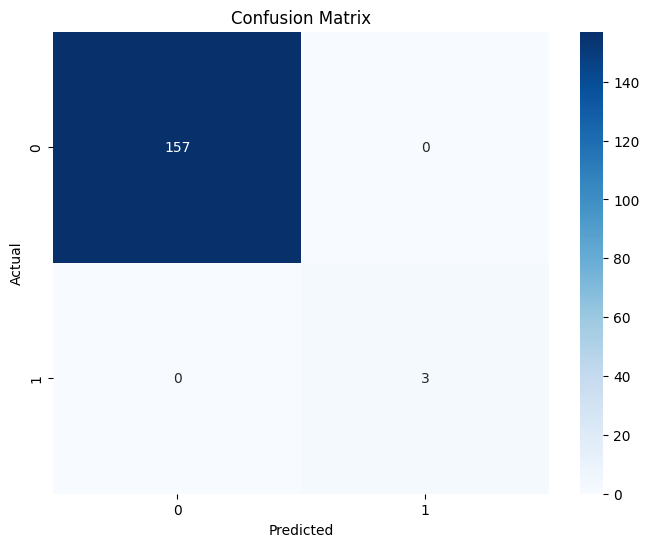

In [68]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [69]:
# Performing 5-fold cross-validation

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Printing the cross-validation scores

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean():.2f}')

Cross-Validation Scores: [1.         0.99212598 1.         1.         0.98425197]
Mean CV Score: 1.00


### Model 1 hyperparameter tuning

In [72]:
# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [73]:
# Initializing Grid Search

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [74]:
# Fitting Grid Search

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [75]:
# Best hyperparameters

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [76]:
# Best model

best_rf_model = grid_search.best_estimator_

In [77]:
# Predicting with the best model

y_pred_best = best_rf_model.predict(X_test)

In [78]:
# Evaluating the best model

best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {best_accuracy:.2f}')

Best Model Accuracy: 1.00


### Model 1 ROC Curve

In [80]:
# Calculate the probability scores for the positive class

y_prob = best_rf_model.predict_proba(X_test)[:, 1]

In [81]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [82]:
# Calculate AUC

roc_auc = auc(fpr, tpr)

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

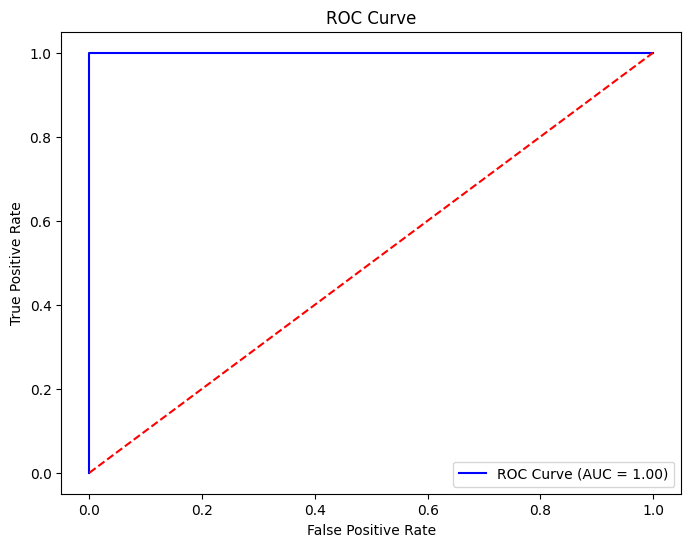

In [83]:
# Plotting the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model 1 Feature Importance

In [86]:
# Get feature importance from the model

importances = best_rf_model.feature_importances_

In [87]:
# Create a DataFrame to hold feature names and their importance scores

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

In [88]:
# Sort by importance

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Importance', ylabel='Feature'>

Text(0.5, 1.0, 'Feature Importance')

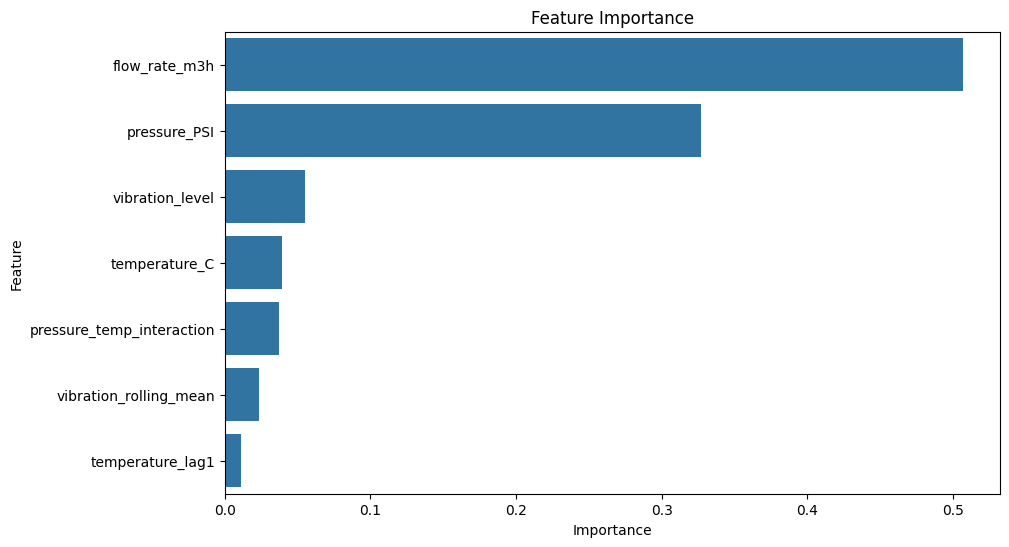

In [89]:
# Plot feature importance

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

## 5. Model 2 Development

In [90]:
# Original dataset

df

timestamp  vibration_level  temperature_C  pressure_PSI  \
0   2024-01-01 00:00:00         0.549671      76.996777     93.248217   
1   2024-01-01 01:00:00         0.486174      74.623168     98.554813   
2   2024-01-01 02:00:00         0.564769      70.298152     92.075801   
3   2024-01-01 03:00:00         0.652303      66.765316     96.920385   
4   2024-01-01 04:00:00         0.476585      73.491117     81.063853   
..                  ...              ...            ...           ...   
995 2024-02-11 11:00:00         0.471890      75.350751    100.774805   
996 2024-02-11 12:00:00         0.679769      69.867394    102.577525   
997 2024-02-11 13:00:00         0.564084      65.590627     87.582394   
998 2024-02-11 14:00:00         0.442882      69.184665    103.341764   
999 2024-02-11 15:00:00         0.557258      66.275487     98.447410   

     flow_rate_m3h  failure  
0        40.460962        0  
1        45.698075        0  
2        47.931972        0  
3        59.438438        0  
4        52.782766        0  
..             ...      ...  
995      50.142288        0  
996      39.610941        1  
997      48.398511        0  
998      58.216891        0  
999      51.803239        0  

[1000 rows x 6 columns]

In [92]:
# Dataset information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1000 non-null   datetime64[ns]
 1   vibration_level  1000 non-null   float64       
 2   temperature_C    1000 non-null   float64       
 3   pressure_PSI     1000 non-null   float64       
 4   flow_rate_m3h    1000 non-null   float64       
 5   failure          1000 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 47.0 KB


In [93]:
# Set 'timestamp' as the index

df.set_index('timestamp', inplace=True)

In [94]:
# input x is separated from output y

x = df.drop(['failure'], axis = 1)

# output y is the 'failure' column

y = df.failure

In [95]:
# Split the data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=42)

Accuracy: 95.000000000%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       281
           1       1.00      0.21      0.35        19

    accuracy                           0.95       300
   macro avg       0.97      0.61      0.66       300
weighted avg       0.95      0.95      0.93       300



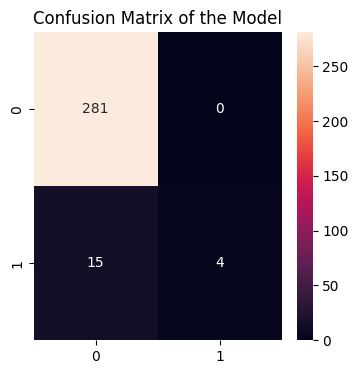

Accuracy: 100.000000000%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      1.00      1.00        19

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



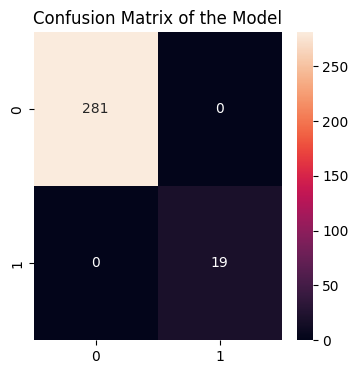

Accuracy: 99.666666667%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      0.95      0.97        19

    accuracy                           1.00       300
   macro avg       1.00      0.97      0.99       300
weighted avg       1.00      1.00      1.00       300



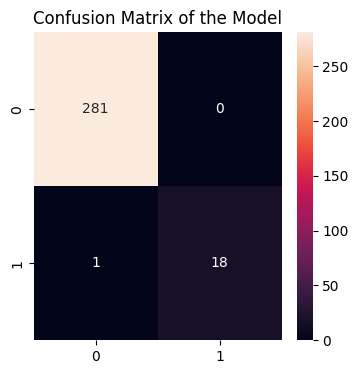

In [96]:
# Creating a function that trains multiple models, with evaluations for each model on the original dataset without feature engineering

def train_and_evaluate_model(algorithm, x_train, x_test, y_train, y_test):
    if algorithm == 'LogisticRegression':
        model = LogisticRegression()
    elif algorithm == 'RandomForest':
        model = RandomForestClassifier()
    elif algorithm == 'XGBoost':
        model = xgb.XGBClassifier()
    else:
        raise ValueError("Unsupported algorithm")

    # Train the model
    model.fit(x_train, y_train)

    # Make predictions
    predictions = model.predict(x_test)

    # Evaluate the model
    acc_score = accuracy_score(y_test, predictions)
    print(f'Accuracy: {acc_score * 100:.9f}%')

    # Print classification report
    print(classification_report(y_test, predictions))

    # Plot the confusion matrix
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix of the Model')
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='.5g')
    plt.show()


train_and_evaluate_model('LogisticRegression', x_train, x_test, y_train, y_test)
train_and_evaluate_model('RandomForest', x_train, x_test, y_train, y_test)
train_and_evaluate_model('XGBoost', x_train, x_test, y_train, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.9966666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      0.95      0.97        19

    accuracy                           1.00       300
   macro avg       1.00      0.97      0.99       300
weighted avg       1.00      1.00      1.00       300



<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix of the XGBoost Model')

<Axes: title={'center': 'Confusion Matrix of the XGBoost Model'}>

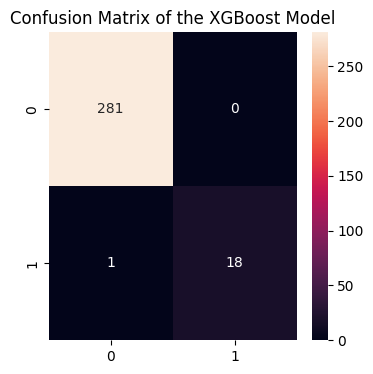

In [97]:
# The code above showed that the XGBoost offers the best performance, with a realistic accuracy score
# Now we repeat the proess again, only for the XGBoost model, for further analysis below it


# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Initialize and train an XGBoost classifier
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

# Make predictions
predictions = model.predict(x_test)

# Calculate class probabilities
class_probabilities = model.predict_proba(x_test)

# Class 1 probabilities (fraudulent class)
fraud_probabilities = class_probabilities[:, 1]

# Evaluate the model
acc_score = accuracy_score(y_test, predictions)
print('Accuracy:', acc_score)

# Print classification report
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.title('Confusion Matrix of the XGBoost Model')
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='.5g')
plt.show()

In [98]:
# Create predictions for the model

predictions = model.predict(x_test)

In [99]:
# roc_auc_score 

roc_auc_score(y_test, predictions)

0.9736842105263157

In [100]:
# Statistical analysis for the predictions

pd.DataFrame(predictions).describe()

0
count  300.000000
mean     0.060000
std      0.237884
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

In [101]:
# Round the probabilities that are above 50% to 1, as an example of how failures may be determined

pred_round = np.where(predictions <= 0.5, 0, 1)

VotingClassifier(estimators=[('random_forest', RandomForestClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

Accuracy of Ensemble Model: 99.67%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      0.95      0.97        19

    accuracy                           1.00       300
   macro avg       1.00      0.97      0.99       300
weighted avg       1.00      1.00      1.00       300



<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix of the Ensemble Model')

<Axes: title={'center': 'Confusion Matrix of the Ensemble Model'}>

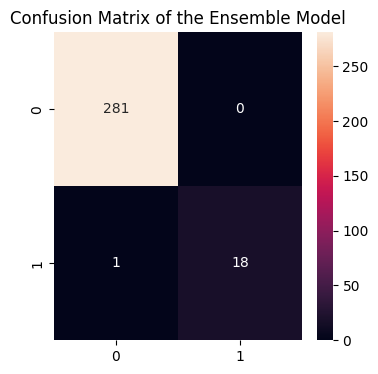

In [103]:
# Create an Ensemble model with random forest and xgboost, in an attempt to improve the model performance

# Initialize individual models
random_forest_model = RandomForestClassifier()
xgboost_model = xgb.XGBClassifier()

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('random_forest', random_forest_model),
    ('xgboost', xgboost_model)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(x_train, y_train)

# Make predictions
ensemble_predictions = ensemble_model.predict(x_test)

# Evaluate the ensemble model
acc_score = accuracy_score(y_test, ensemble_predictions)
print(f'Accuracy of Ensemble Model: {acc_score * 100:.2f}%')

# Print classification report
print(classification_report(y_test, ensemble_predictions))

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.title('Confusion Matrix of the Ensemble Model')
sns.heatmap(confusion_matrix(y_test, ensemble_predictions), annot=True, fmt='.5g')
plt.show()

## 6. Simulation on the models

### Simulating test data and using model 1 

In [112]:
# Save the model

joblib.dump(best_rf_model, 'pump_failure_model.pkl')

['pump_failure_model.pkl']

In [113]:
# Load the model

model = joblib.load('pump_failure_model.pkl')

In [115]:
# Simulate new sensor data (replace with actual new data)

new_data = pd.DataFrame({
    'vibration_level': [0.1, 0.2],
    'temperature_C': [75, 80],
    'pressure_PSI': [30, 35],
    'flow_rate_m3h': [10, 15]
})

In [116]:
# Reapply feature engineering to new data

new_data['pressure_temp_interaction'] = new_data['pressure_PSI'] * new_data['temperature_C']
new_data['temperature_lag1'] = new_data['temperature_C'].shift(1).fillna(new_data['temperature_C'].iloc[0])
new_data['vibration_rolling_mean'] = new_data['vibration_level'].rolling(window=3).mean().fillna(new_data['vibration_level'])

In [117]:
# Ensure the columns are in the same order as the model was trained on

new_data = new_data[['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h', 
                     'vibration_rolling_mean', 'temperature_lag1', 'pressure_temp_interaction']]

In [118]:
# Make predictions

predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)[:, 1]

In [119]:
# Output the predictions

for i, prob in enumerate(probabilities):
    print(f"Pump {i+1} Failure Probability: {prob:.2f}")

Pump 1 Failure Probability: 0.84
Pump 2 Failure Probability: 0.81


### Simulating more data

In [120]:
# Set a random seed for reproducibility

np.random.seed(42)

# Define the number of samples you want to simulate

num_samples = 1000

In [121]:
# Simulate data within typical ranges

simulated_data = pd.DataFrame({
    'vibration_level': np.random.uniform(0.2, 0.9, num_samples),
    'temperature_C': np.random.uniform(55, 86, num_samples),
    'pressure_PSI': np.random.uniform(74, 140, num_samples),
    'flow_rate_m3h': np.random.uniform(37, 67, num_samples)
})

In [122]:
# Reapply feature engineering to the simulated data

simulated_data['pressure_temp_interaction'] = simulated_data['pressure_PSI'] * simulated_data['temperature_C']
simulated_data['temperature_lag1'] = simulated_data['temperature_C'].shift(1).fillna(simulated_data['temperature_C'].iloc[0])
simulated_data['vibration_rolling_mean'] = simulated_data['vibration_level'].rolling(window=3).mean().fillna(simulated_data['vibration_level'])

In [123]:
# Ensure the columns are in the correct order for the model

simulated_data = simulated_data[['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h', 
                                 'vibration_rolling_mean', 'temperature_lag1', 'pressure_temp_interaction']]

In [124]:
# Load the model

model = joblib.load('pump_failure_model.pkl')

In [125]:
# Make predictions

predictions = model.predict(simulated_data)
probabilities = model.predict_proba(simulated_data)[:, 1]

In [126]:
# Output a few sample predictions

for i in range(5):                                                   # Print the first 5 predictions as an example
    print(f"Pump {i+1} Failure Probability: {probabilities[i]:.2f}")

Pump 1 Failure Probability: 0.81
Pump 2 Failure Probability: 0.81
Pump 3 Failure Probability: 0.81
Pump 4 Failure Probability: 0.81
Pump 5 Failure Probability: 0.81


In [127]:
# Save the simulated predictions to a CSV file
simulated_data['failure_probability'] = probabilities
simulated_data.to_csv('simulated_pump_failure_predictions_model_1.csv', index=False)

### Simulating test data and using model 2

In [128]:
# Save the model

joblib.dump(ensemble_model, 'pump_failure_model.pkl')

['pump_failure_model.pkl']

In [129]:
# Load the model

model = joblib.load('pump_failure_model.pkl')

In [130]:
# Set a random seed for reproducibility

np.random.seed(42)

# Define the number of samples you want to simulate

num_samples = 100000

In [131]:
# Simulate data within typical ranges

simulated_data = pd.DataFrame({
    'vibration_level': np.random.uniform(0.2, 0.9, num_samples),
    'temperature_C': np.random.uniform(55, 86, num_samples),
    'pressure_PSI': np.random.uniform(74, 140, num_samples),
    'flow_rate_m3h': np.random.uniform(37, 67, num_samples)
})

In [132]:
# Ensure the columns are in the correct order for the model

simulated_data = simulated_data[['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']]

In [133]:
# Load the model

model = joblib.load('pump_failure_model.pkl')

In [134]:
# Make predictions

predictions = model.predict(simulated_data)
probabilities = model.predict_proba(simulated_data)[:, 1]

In [144]:
# Output a few sample predictions

for i in range(5):                                                   # Print the first 5 predictions as an example
    print(f"Pump {i+1} Failure Probability: {probabilities[i]:.2f}")

Pump 1 Failure Probability: 0.00
Pump 2 Failure Probability: 0.94
Pump 3 Failure Probability: 0.01
Pump 4 Failure Probability: 0.00
Pump 5 Failure Probability: 0.00


In [136]:
# Save the simulated predictions to a CSV file

simulated_data['failure_probability'] = probabilities
simulated_data.to_csv('simulated_pump_failure_predictions_model_2.csv', index=False)

## 7. Advanced feature engineering attempt

### Feature Engineering: Rolling Averages, Exponential Moving Averages, Trend Indicators and Cumulative Sum

In [145]:
# Rolling averages over different window sizes

df['vibration_rolling_mean_3'] = df['vibration_level'].rolling(window=3).mean()
df['vibration_rolling_mean_7'] = df['vibration_level'].rolling(window=7).mean()

df['temperature_rolling_mean_3'] = df['temperature_C'].rolling(window=3).mean()
df['temperature_rolling_mean_7'] = df['temperature_C'].rolling(window=7).mean()

df['pressure_rolling_mean_3'] = df['pressure_PSI'].rolling(window=3).mean()
df['pressure_rolling_mean_7'] = df['pressure_PSI'].rolling(window=7).mean()

df['flow_rate_rolling_mean_3'] = df['flow_rate_m3h'].rolling(window=3).mean()
df['flow_rate_rolling_mean_7'] = df['flow_rate_m3h'].rolling(window=7).mean()

In [146]:
# Exponential Moving Averages

df['vibration_ema'] = df['vibration_level'].ewm(span=10, adjust=False).mean()
df['temperature_ema'] = df['temperature_C'].ewm(span=10, adjust=False).mean()
df['pressure_ema'] = df['pressure_PSI'].ewm(span=10, adjust=False).mean()
df['flow_rate_ema'] = df['flow_rate_m3h'].ewm(span=10, adjust=False).mean()

In [147]:
# Trend Indicators: Difference between successive readings

df['vibration_diff'] = df['vibration_level'].diff()
df['temperature_diff'] = df['temperature_C'].diff()
df['pressure_diff'] = df['pressure_PSI'].diff()
df['flow_rate_diff'] = df['flow_rate_m3h'].diff()

In [148]:
# Cumulative sum of differences to capture long-term trends

df['vibration_cum_diff'] = df['vibration_diff'].cumsum()
df['temperature_cum_diff'] = df['temperature_diff'].cumsum()
df['pressure_cum_diff'] = df['pressure_diff'].cumsum()
df['flow_rate_cum_diff'] = df['flow_rate_diff'].cumsum()

In [157]:
# Drop any rows with NaN values resulting from rolling calculations

df.dropna(inplace=True)

# Convert the timestamp to datetime format

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set 'timestamp' as the index

df.set_index('timestamp', inplace=True)

In [158]:
# Split the data into training and testing sets

x = df.drop(['failure'], axis=1)
y = df['failure']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [159]:
# Viewing the dataframe with the new features

df

vibration_level  temperature_C  pressure_PSI  \
timestamp                                                           
2024-01-01 12:00:00         0.524196      80.376304     92.308577   
2024-01-01 13:00:00         0.308672      66.554061     90.600969   
2024-01-01 14:00:00         0.327508      78.679819    108.294748   
2024-01-01 15:00:00         0.443771      70.989554     98.061739   
2024-01-01 16:00:00         0.398717      66.742910     97.354852   
...                              ...            ...           ...   
2024-02-11 11:00:00         0.471890      75.350751    100.774805   
2024-02-11 12:00:00         0.679769      69.867394    102.577525   
2024-02-11 13:00:00         0.564084      65.590627     87.582394   
2024-02-11 14:00:00         0.442882      69.184665    103.341764   
2024-02-11 15:00:00         0.557258      66.275487     98.447410   

                     flow_rate_m3h  failure  vibration_rolling_mean_3  \
timestamp                                                               
2024-01-01 12:00:00      43.564182        0                  0.477094   
2024-01-01 13:00:00      43.014409        0                  0.428765   
2024-01-01 14:00:00      47.082003        0                  0.386792   
2024-01-01 15:00:00      55.191894        0                  0.359984   
2024-01-01 16:00:00      42.403270        0                  0.389999   
...                            ...      ...                       ...   
2024-02-11 11:00:00      50.142288        0                  0.434510   
2024-02-11 12:00:00      39.610941        1                  0.517166   
2024-02-11 13:00:00      48.398511        0                  0.571914   
2024-02-11 14:00:00      58.216891        0                  0.562245   
2024-02-11 15:00:00      51.803239        0                  0.521408   

                     vibration_rolling_mean_7  temperature_rolling_mean_3  \
timestamp                                                                   
2024-01-01 12:00:00                  0.524751                   75.983758   
2024-01-01 13:00:00                  0.474858                   72.639454   
2024-01-01 14:00:00                  0.439253                   75.203395   
2024-01-01 15:00:00                  0.437927                   72.074478   
2024-01-01 16:00:00                  0.415707                   72.137428   
...                                       ...                         ...   
2024-02-11 11:00:00                  0.442595                   73.549837   
2024-02-11 12:00:00                  0.467892                   72.325129   
2024-02-11 13:00:00                  0.474070                   70.269591   
2024-02-11 14:00:00                  0.495078                   68.214229   
2024-02-11 15:00:00                  0.506789                   67.016926   

                     temperature_rolling_mean_7  pressure_rolling_mean_3  \
timestamp                                                                  
2024-01-01 12:00:00                   74.024955                89.535243   
2024-01-01 13:00:00                   72.893254                91.760766   
2024-01-01 14:00:00                   73.679534                97.068098   
2024-01-01 15:00:00                   73.071219                98.985819   
2024-01-01 16:00:00                   72.988231               101.237113   
...                                         ...                      ...   
2024-02-11 11:00:00                   73.789599                96.377844   
2024-02-11 12:00:00                   73.462139                97.944382   
2024-02-11 13:00:00                   72.260508                96.978242   
2024-02-11 14:00:00                   71.605252                97.833895   
2024-02-11 15:00:00                   70.223955                96.457189   

                     pressure_rolling_mean_7  flow_rate_rolling_mean_3  \
timestamp                                                                
2024-01-01 12:00:00               

Logistic Regression Model:
Accuracy: 96.296296296%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       284
           1       0.62      0.38      0.48        13

    accuracy                           0.96       297
   macro avg       0.80      0.69      0.73       297
weighted avg       0.96      0.96      0.96       297



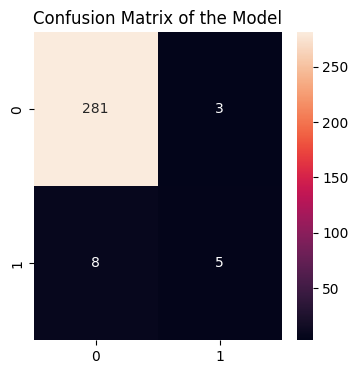

In [160]:
# Logistic Regression Model

print("Logistic Regression Model:")
train_and_evaluate_model('LogisticRegression', x_train, x_test, y_train, y_test)

Random Forest Model:
Accuracy: 100.000000000%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      1.00      1.00        13

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



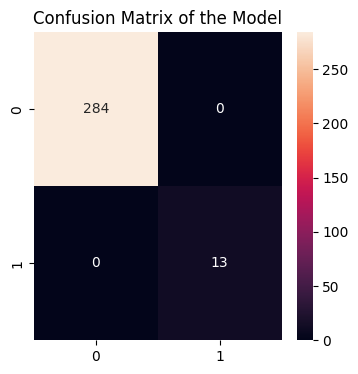

In [161]:
# Random Forest Model

print("Random Forest Model:")
train_and_evaluate_model('RandomForest', x_train, x_test, y_train, y_test)

XGBoost Model:
Accuracy: 99.663299663%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       0.93      1.00      0.96        13

    accuracy                           1.00       297
   macro avg       0.96      1.00      0.98       297
weighted avg       1.00      1.00      1.00       297



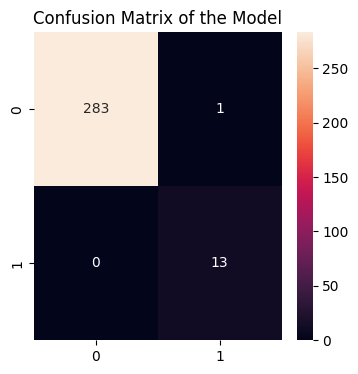

In [162]:
# XGBoost Model

print("XGBoost Model:")
train_and_evaluate_model('XGBoost', x_train, x_test, y_train, y_test)

In [163]:
# Ensemble Model using Voting Classifier with Logistic Regression, Random Forest and XGBoost

print("Ensemble Model (Logistic Regression + Random Forest + XGBoost):")
ensemble_model = VotingClassifier(estimators=[
    ('logistic_regression', LogisticRegression()),
    ('random_forest', RandomForestClassifier()),
    ('xgboost', xgb.XGBClassifier())
], voting='soft')

Ensemble Model (Logistic Regression + Random Forest + XGBoost):


In [165]:
# Train the ensemble model

ensemble_model.fit(x_train, y_train)

VotingClassifier(estimators=[('logistic_regression', LogisticRegression()),
                             ('random_forest', RandomForestClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=No...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [166]:
# Make predictions with the ensemble model

ensemble_predictions = ensemble_model.predict(x_test)

In [167]:
# Evaluate the ensemble model

acc_score = accuracy_score(y_test, ensemble_predictions)
print(f'Accuracy of Ensemble Model: {acc_score * 100:.2f}%')

Accuracy of Ensemble Model: 100.00%


In [168]:
# Print classification report for the ensemble model

print(classification_report(y_test, ensemble_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      1.00      1.00        13

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix of the Ensemble Model')

<Axes: title={'center': 'Confusion Matrix of the Ensemble Model'}>

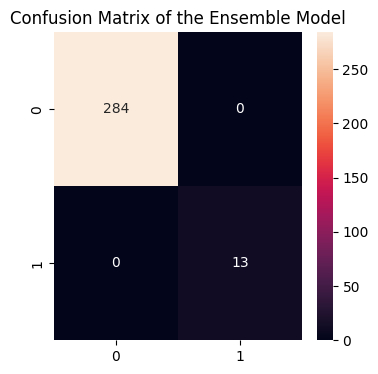

In [169]:
# Plot the confusion matrix for the ensemble model

plt.figure(figsize=(4, 4))
plt.title('Confusion Matrix of the Ensemble Model')
sns.heatmap(confusion_matrix(y_test, ensemble_predictions), annot=True, fmt='.5g')
plt.show()

### Simulation for the ensemble model after advanced feature engineering

In [170]:
# Save the final ensemble model

joblib.dump(ensemble_model, 'pump_failure_ensemble_model_after_feature_engineering.pkl')

['pump_failure_ensemble_model_after_feature_engineering.pkl']

In [174]:
# Set a random seed for reproducibility

np.random.seed(42)

# Define the number of samples you want to simulate

num_samples = 100000

In [175]:
# Simulate data within typical ranges

simulated_data = pd.DataFrame({
    'vibration_level': np.random.uniform(0.2, 0.9, num_samples),
    'temperature_C': np.random.uniform(55, 86, num_samples),
    'pressure_PSI': np.random.uniform(74, 140, num_samples),
    'flow_rate_m3h': np.random.uniform(37, 67, num_samples)
})

In [183]:
# The 'timestamp' is set for the simulated data to calculate rolling features

simulated_data['timestamp'] = pd.date_range(start='1/1/2024', periods=len(simulated_data), freq='T')
simulated_data.set_index('timestamp', inplace=True)

In [184]:
# Rolling averages over different window sizes

simulated_data['vibration_rolling_mean_3'] = simulated_data['vibration_level'].rolling(window=3).mean()
simulated_data['vibration_rolling_mean_7'] = simulated_data['vibration_level'].rolling(window=7).mean()

simulated_data['temperature_rolling_mean_3'] = simulated_data['temperature_C'].rolling(window=3).mean()
simulated_data['temperature_rolling_mean_7'] = simulated_data['temperature_C'].rolling(window=7).mean()

simulated_data['pressure_rolling_mean_3'] = simulated_data['pressure_PSI'].rolling(window=3).mean()
simulated_data['pressure_rolling_mean_7'] = simulated_data['pressure_PSI'].rolling(window=7).mean()

simulated_data['flow_rate_rolling_mean_3'] = simulated_data['flow_rate_m3h'].rolling(window=3).mean()
simulated_data['flow_rate_rolling_mean_7'] = simulated_data['flow_rate_m3h'].rolling(window=7).mean()

In [185]:
# Exponential Moving Averages

simulated_data['vibration_ema'] = simulated_data['vibration_level'].ewm(span=10, adjust=False).mean()
simulated_data['temperature_ema'] = simulated_data['temperature_C'].ewm(span=10, adjust=False).mean()
simulated_data['pressure_ema'] = simulated_data['pressure_PSI'].ewm(span=10, adjust=False).mean()
simulated_data['flow_rate_ema'] = simulated_data['flow_rate_m3h'].ewm(span=10, adjust=False).mean()

In [186]:
# Trend Indicators: Difference between successive readings

simulated_data['vibration_diff'] = simulated_data['vibration_level'].diff()
simulated_data['temperature_diff'] = simulated_data['temperature_C'].diff()
simulated_data['pressure_diff'] = simulated_data['pressure_PSI'].diff()
simulated_data['flow_rate_diff'] = simulated_data['flow_rate_m3h'].diff()

In [187]:
# Cumulative sum of differences to capture long-term trends

simulated_data['vibration_cum_diff'] = simulated_data['vibration_diff'].cumsum()
simulated_data['temperature_cum_diff'] = simulated_data['temperature_diff'].cumsum()
simulated_data['pressure_cum_diff'] = simulated_data['pressure_diff'].cumsum()
simulated_data['flow_rate_cum_diff'] = simulated_data['flow_rate_diff'].cumsum()

In [188]:
# Simulated data df

simulated_data

vibration_level  temperature_C  pressure_PSI  \
timestamp                                                           
2024-01-01 00:00:00         0.240659      80.885919    105.555429   
2024-01-01 00:01:00         0.806323      79.393728    132.495845   
2024-01-01 00:02:00         0.620781      65.561465    112.174882   
2024-01-01 00:03:00         0.695651      70.792004     75.166096   
2024-01-01 00:04:00         0.214409      55.330345     83.471767   
...                              ...            ...           ...   
2024-03-10 10:29:00         0.754613      74.286649     80.125503   
2024-03-10 10:30:00         0.745477      74.505836    115.291675   
2024-03-10 10:31:00         0.672117      60.958314    115.359670   
2024-03-10 10:32:00         0.549613      75.245563     77.144896   
2024-03-10 10:33:00         0.472936      55.048362    120.469098   

                     flow_rate_m3h  vibration_rolling_mean_3  \
timestamp                                                      
2024-01-01 00:00:00      50.253973                       NaN   
2024-01-01 00:01:00      38.000709                       NaN   
2024-01-01 00:02:00      55.002244                  0.555921   
2024-01-01 00:03:00      47.185990                  0.707585   
2024-01-01 00:04:00      57.067158                  0.510280   
...                            ...                       ...   
2024-03-10 10:29:00      59.504449                  0.678255   
2024-03-10 10:30:00      45.175834                  0.763611   
2024-03-10 10:31:00      54.267661                  0.724069   
2024-03-10 10:32:00      63.800194                  0.655736   
2024-03-10 10:33:00      52.072680                  0.564889   

                     vibration_rolling_mean_7  temperature_rolling_mean_3  \
timestamp                                                                   
2024-01-01 00:00:00                       NaN                         NaN   
2024-01-01 00:01:00                       NaN                         NaN   
2024-01-01 00:02:00                       NaN                   75.280371   
2024-01-01 00:03:00                       NaN                   71.915732   
2024-01-01 00:04:00                       NaN                   63.894605   
...                                       ...                         ...   
2024-03-10 10:29:00                  0.617655                   63.950810   
2024-03-10 10:30:00                  0.666944                   68.402165   
2024-03-10 10:31:00                  0.655996                   69.916933   
2024-03-10 10:32:00                  0.693475                   70.236571   
2024-03-10 10:33:00                  0.639273                   63.750747   

                     temperature_rolling_mean_7  pressure_rolling_mean_3  \
timestamp                                                                  
2024-01-01 00:00:00                         NaN                      NaN   
2024-01-01 00:01:00                         NaN                      NaN   
2024-01-01 00:02:00                         NaN               116.742052   
2024-01-01 00:03:00                         NaN               106.612274   
2024-01-01 00:04:00                         NaN                90.270915   
...                                         ...                      ...   
2024-03-10 10:29:00                   71.400613               106.301295   
2024-03-10 10:30:00                   70.451310               107.849830   
2024-03-10 10:31:00                   67.315216               103.592283   
2024-03-10 10:32:00                   66.489102               102.598747   
2024-03-10 10:33:00                   65.372929               104.324555   

                     pressure_rolling_mean_7  flow_rate_rolling_mean_3  \
timestamp                                                                
2024-01-01 00:00:00                      NaN                       NaN   
2024-01-01 00:01:00                      NaN                       NaN   
202

In [189]:
# Drop any rows with NaN values resulting from rolling calculations

simulated_data.dropna(inplace=True)

In [190]:
# Load the saved ensemble model

model = joblib.load('pump_failure_ensemble_model_after_feature_engineering.pkl')

In [191]:
# Make predictions with the simulated data

predictions = model.predict(simulated_data)
probabilities = model.predict_proba(simulated_data)[:, 1]

In [192]:
# Output a few sample predictions

for i in range(5):                                                   # Print the first 5 predictions as an example
    print(f"Pump {i+1} Failure Probability: {probabilities[i]:.2f}")

Pump 1 Failure Probability: 0.11
Pump 2 Failure Probability: 0.06
Pump 3 Failure Probability: 0.03
Pump 4 Failure Probability: 0.05
Pump 5 Failure Probability: 0.81


In [193]:
# Save the simulated predictions to a CSV file

simulated_data['failure_probability'] = probabilities
simulated_data.to_csv('simulated_pump_failure_predictions_with_engineered_features.csv', index=False)

# Thank you